# Hate Speech Project

## Introduction

__Hate speech__ is defined by the _Cambridge Dictionary_ as "_public speech that expresses hate or encourages violence towards a person or group based on something such as race, religion, sex, or sexual orientation_".[[1](https://dictionary.cambridge.org/us/dictionary/english/hate-speech)]  
Hate speech is "_usually thought to include communications of animosity or disparagement of an individual or a group on account of a group characteristic such as race, colour, national origin, sex, disability, religion, or sexual orientation_".[[2](http://southernlibrarianship.icaap.org/content/v09n02/brown-sica_m01.html#_edn2)]  
A legal definition of hate speech varies from country to country.

Source: [Wikipedia article on "Hate speech"](https://en.wikipedia.org/wiki/Hate_speech)

Given the huge amount of user-generated contents on Twitter, the problem of detecting, and therefore possibly contrasting the HS diffusion, is becoming fundamental, for instance for fighting against misogyny and xenophobia. To this end, in this task, we aim at identifying possible hate speech spreaders on Twitter as a first step towards preventing hate speech from being propagated among online users.  

The project's idea is __to develop a model that can determine whether its author spreads hate speech, given a Twitter feed__.

## Dataset description

The dataset contains timelines of users sharing hate speech towards, for instance, immigrants and women, __100 training cases / authors__ each (with __100 tweets per author__).

The data directory contains __a XML file per author (Twitter user)__.

The name of the XML file corresponds to the unique autor id.

Moreover, a `truth.txt` file with the list of authors and the ground truth. The format of the XML files and the `truth.txt` are as follows:

__Author file (XML)__:
```xml
<author lang="en>
    <documents>
        <document>Tweet 1 textual contents</document>
        <document>Tweet 2 textual contents</document>
        ...
    </documents>
</author>
```

__Truth file__:
```
639b8e5e6a527d494c85d8f5704b1a01:::0
f2b1fc84c500c38a93522efbd422b559:::0
10b2d013382e1fb3c9414ea28329f258:::0
26644d1348fc1122e8c5ef45d6bc84fa:::0
4d4c5dcbfe38d0d33a0d1b1419952ca8:::0
86a7f84c2dd126dac46270b6c912952c:::0
88d8ac4ae2d91e681ee8a8d3b60fd911:::0
2a9776a2909ba5e27043faf2d57ba410:::0
fdb47a3f65091b9a5b989e1722c9fac4:::0
5625ca3bc44c89d763221b663f7c0987:::0
```

## Mission

__The final objective is to build a system that can predict if a user in social media is a hate speech spreader or not.__

The output of the system can be used as a filtering module in online social media.

## Tasks

Following tasks need to be accomplished:
1. Understand the content that is available in the dataset .
2. Pre-process the data to improve the final results.
3. Baseline model
4. LSTM model
5. Compare the results of both models using the F1 measure.
6. _(Optional)_ Think about further steps to improve your performance, such as pre processing, feature embeddings, post processing etc. and try them out if you have time.

# Python imports

In [1]:
!pip install emot --upgrade
!pip install contractions --upgrade

     |████████████████████████████████| 61 kB 14 kB/s 
     |████████████████████████████████| 321 kB 7.0 MB/s 
     |████████████████████████████████| 284 kB 53.2 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85449 sha256=91f4e5cd4e81cce0a499a4eb22864cda0dced68dec73f822cddfde2a34009c24
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [48]:
# Data loading
import os
import pandas as pd
import re
import numpy as np

# Data parsing
from tqdm import tqdm
from xml.dom import minidom

# EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing
import emot
import timeit
import nltk
import operator
import contractions
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import pickle

# Model
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, GRU, Bidirectional, BatchNormalization

# Evaluation
from sklearn.metrics import f1_score, ConfusionMatrixDisplay

# Data loading

We need to parse lots of XML files and add everything into a huge pandas DataFrame.  
So the idea is as follows:
* for each language `("en", "es")`
* for each author / file
* read all tweets

In [ ]:
data_dir="/work/data"

## Reading tweets from a given file

In [ ]:
# Testing the XML parsing of a file
xml_file=open(data_dir + "/en/043e2766cc6d22ae4e447ca5f2885a2a.xml")

# Setting up parser for the file
parser = minidom.parse(xml_file)

In [ ]:
# Using the parser to get first [0] tweet
tweet = parser.getElementsByTagName('document')[0].firstChild.wholeText

print(tweet)

Fuck New York #URL#


In [ ]:
tweets = parser.getElementsByTagName('document')

for tweet in tweets:
    print(tweet.firstChild.wholeText)

Fuck New York #URL#
#USER# #USER# I think I'm in love
Trump is awesome #URL#
#USER# You have the greatest tweets sweetheart #USER#
#USER# It's free pizza Hun, just free food
#USER# Love you Joy
Can I help CNN, I can piss on ya #URL#
She IS a wet potato sack #URL#
#USER# Long gone darlin
I like them too #URL#
RT #USER#: RETWEET if you think Michael Moore is a worthless Loser! #URL#
RT #USER#: Did CNN just re-unite the alt-right &amp; the new right in a common cause? 🤔 #URL#
Oh, a willnot #URL#
RT #USER#: Hey #USER#! Just saw a 12 year old with a video camera and a Trump t-shirt, might want to pay this clown a visit
#USER# is so low, he can crawl under a snake and not alert it, better yet, he's a goof #URL#
Let me get that for ya honey #URL#
I'll eat what the fuck I want #URL#
#USER# you mean this asshole, yep you nailed it, he is an asshole #URL#
Wow #USER# at those jeans #URL#
What USA looks like today #URL#
RT #USER#: TV RATINGS: Fox News has 14 of the top 20 cable news shows in total

## Getting languages and file list

We need to list a content of the data dictionary and assume everything found is a "language" subfolder.  
  
```
(venv) root@deepnote:~/work # ls data
en  es
```  
</br>  
These are two subfolders for English (`"en"`) and Spanish ('"es"`) users.

In [ ]:
# We will store the available languages into this "langs" list
langs = []

# Iterate through the data_dir content:
for item in os.listdir(data_dir):
    print(item)
    langs.append(item)

es
en


In [ ]:
langs

['es', 'en']

## Loading tweets

Following block will:
  - scan through the `data` directory and for each language found
  - scan all the files (taking only the XML files)
  - read all the tweets
  - append this all into a huge pandas DataFrame  

In [ ]:
# Create empty dataframe with specified columns
userid_pattern = "[a-z0-9]{32}"
twitter_file_pattern = userid_pattern + "\.xml"
columns = ["lang", "userid", "tweet"]
data = pd.DataFrame(columns=columns)

# Scan data directory for languages and XML files
for lang in os.listdir(data_dir):
    
    # Scan files in language directory
    for item in tqdm(os.listdir(data_dir + "/" + lang), desc=f"Loading files [{lang}]..."):
        
        # Twitter XML file filter:
        if re.search(twitter_file_pattern, item):

            # Extract userid from file name
            userid = item[:-4]

            # Open XML file and setup parser
            xml_file = open(data_dir + "/" + lang + "/" + item)
            parser = minidom.parse(xml_file)

            # Parse tweets
            tweets = parser.getElementsByTagName('document')

            # Add each tweet to a dataframe
            for tweet in tweets:
                addition = pd.DataFrame([[lang, userid, tweet.firstChild.wholeText]], columns=columns)
                data = data.append(addition, ignore_index=True)

Loading files [en]...: 100%|██████████| 201/201 [03:18<00:00,  1.01it/s]


The processing of the XML files took ~5 minutes. To save time I decided to store it later to a CSV file, so next time we can load it very quickly.

In [ ]:
data.head()

,lang,userid,tweet
0,es,223d8277fe1f9895a83a385010218989,"#USER# #USER# Me gusta la VALENCIANA, es mucha..."
1,es,223d8277fe1f9895a83a385010218989,RT #USER#: La crítica de Pablo Echenique a Isa...
2,es,223d8277fe1f9895a83a385010218989,RT #USER#: Errejón se prepara la moción 😂😂😂😂😂😂...
3,es,223d8277fe1f9895a83a385010218989,#USER# #USER# #USER# #USER# #USER# Y esos insu...
4,es,223d8277fe1f9895a83a385010218989,RT #USER#: #USER# #USER# #USER# Sí Sí igual qu...


## Loading truth

In [ ]:
# Testing for presence of a "truth.txt" file
[item for item in os.listdir(data_dir + "/" + lang) if item=="truth.txt"]

['truth.txt']

Following block will load all truth files:

In [ ]:
# Create empty dataframe with specified columns
truth_file_name = "truth.txt"
columns = ["userid", "truth"]
truth = pd.DataFrame(columns=columns)

# Scan data directory for languages and XML files
for lang in langs:
    
    # Scan files in language directory
    for item in tqdm(
        [item for item in os.listdir(data_dir + "/" + lang) if item=="truth.txt"],
        desc=f"Loading truth files [{lang}]..."):
        
        addition = pd.read_csv((data_dir + "/" + lang + "/" + item), sep=":", index_col=False, usecols=[0,3], names=columns)

        truth = truth.append(addition, ignore_index=True)

Loading truth files [en]...: 100%|██████████| 1/1 [00:00<00:00, 152.48it/s]


In [ ]:
truth

,userid,truth
0,1a698d93874644625d83a76b206c7aa3,0
1,b7200193802bde3769f4daa371b5305b,0
2,7ffb758291340303c2162fcee25e2780,0
3,e309e9e2516824370310661c919dd5d8,0
4,b523abc590889dfaf69a1c8470ef314d,0
...,...,...
395,833ffc26e9f1a81265e3e97513cefb86,1
396,dead14502e55f545546f666ab6d91558,1
397,e608b622e6a3085290fc279b55fa821c,1
398,a7d4e6f2aa8543a448b5a07feab9fc49,1


The point is that the label (truth) is 1 per each _author_, not per _tweet_. We have think about how to organize the data for the NN classifier.

If we ever needed to merge `data` and `truth` dataframes together, this is how we could do it:

In [ ]:
# data = data.merge(right=truth, how="left", on="userid")

Now I will save the DataFrames, so we can load them up much quicker after the hardware resets.

In [ ]:
# Commented out after controlled run, so we have done the files right
# data.to_csv("data.csv")
# truth.to_csv("truth.csv")

# Re-loading both data sets

In [ ]:
data = pd.read_csv("data.csv", index_col=0)
truth = pd.read_csv("truth.csv", index_col=0)

In [ ]:
data

,lang,userid,tweet
0,es,223d8277fe1f9895a83a385010218989,"#USER# #USER# Me gusta la VALENCIANA, es mucha..."
1,es,223d8277fe1f9895a83a385010218989,RT #USER#: La crítica de Pablo Echenique a Isa...
2,es,223d8277fe1f9895a83a385010218989,RT #USER#: Errejón se prepara la moción 😂😂😂😂😂😂...
3,es,223d8277fe1f9895a83a385010218989,#USER# #USER# #USER# #USER# #USER# Y esos insu...
4,es,223d8277fe1f9895a83a385010218989,RT #USER#: #USER# #USER# #USER# Sí Sí igual qu...
...,...,...,...
79995,en,e9f06b27f1108050bd27937cbacb1d5e,#USER# #USER# biden raises the dead again
79996,en,e9f06b27f1108050bd27937cbacb1d5e,and has a ———-for a running mate🤮 America has ...
79997,en,e9f06b27f1108050bd27937cbacb1d5e,#USER# should have been done ✅ fair and square...
79998,en,e9f06b27f1108050bd27937cbacb1d5e,#USER# #USER# bullshit...they “found” them pho...


In [ ]:
truth

,userid,truth
0,1a698d93874644625d83a76b206c7aa3,0
1,b7200193802bde3769f4daa371b5305b,0
2,7ffb758291340303c2162fcee25e2780,0
3,e309e9e2516824370310661c919dd5d8,0
4,b523abc590889dfaf69a1c8470ef314d,0
...,...,...
395,833ffc26e9f1a81265e3e97513cefb86,1
396,dead14502e55f545546f666ab6d91558,1
397,e608b622e6a3085290fc279b55fa821c,1
398,a7d4e6f2aa8543a448b5a07feab9fc49,1


# Exploratory Data Analysis

So we're having actually:
* 2 languages (Spanish, English)
* 200 authors per language
* 200 tweets per author

Which equals:
* 400 authors total
* 80000 tweets total
* 400 binary labels

## Class balance

We have fairly balanced classes:

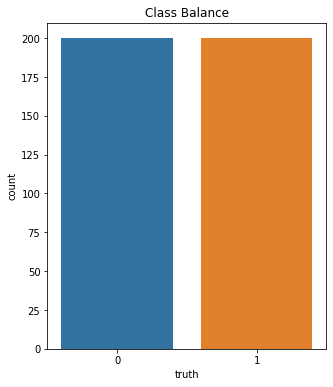

In [ ]:
fig, ax = plt.subplots(figsize=(5,6))

ax = sns.countplot(x="truth", data=truth)
ax.set_title("Class Balance")

plt.show()


## Missing values

Check for missing values in `data`:

In [ ]:
data.isna().sum().sum()

0

Check for missing values in `truth`:

In [ ]:
truth.isna().sum().sum()

0

Check for missing truth assignments (both directions):

In [ ]:
pd.merge(left=data, right=truth, how="left", on="userid").isna().sum().sum()

0

In [ ]:
pd.merge(left=data, right=truth, how="right", on="userid").isna().sum().sum()

0

## Multiplicated tweets

In [ ]:
# Check multiplicated tweets
duplicates = data["tweet"][data["tweet"].duplicated(keep=False)].value_counts()

#duplicates["count"]=1

duplicates.head(50)

one person followed me // automatically checked by #URL#                                                                      91
one person unfollowed me // automatically checked by #URL#                                                                    53
2 people followed me // automatically checked by #URL#                                                                        46
I posted a new video to Facebook #URL#                                                                                        43
one person followed me and one person unfollowed me // automatically checked by #URL#                                         33
2 people followed me and one person unfollowed me // automatically checked by #URL#                                           23
3 people followed me // automatically checked by #URL#                                                                        20
From earlier today #URL#                                                                         

### fllwrs tweets removal

It is apparent that largest part of multiplicated tweets come from [fllwrs](http://fllwrs.com/) app, which checks for changes in user's Twitter followers over time. It records followers that have been added or lost.

These tweets don't come from the authors, so they carry no information for our project. I will now remove all tweets that match to certain regular expression and do multiplicative tweets re-check.

In [ ]:
fllwrs_pattern = "((one|[0-9]+){1} (person|people){1} (un)?followed me){1}( and (one|[0-9]+){1} (person|people){1} (un)?followed me){0,1} // automatically checked by #URL#"

In [ ]:
data[data["tweet"].str.match(fllwrs_pattern)].value_counts("tweet")

tweet
one person followed me // automatically checked by #URL#                                 91
one person unfollowed me // automatically checked by #URL#                               53
2 people followed me // automatically checked by #URL#                                   46
one person followed me and one person unfollowed me // automatically checked by #URL#    33
2 people followed me and one person unfollowed me // automatically checked by #URL#      23
3 people followed me // automatically checked by #URL#                                   20
3 people followed me and one person unfollowed me // automatically checked by #URL#      18
2 people followed me and 2 people unfollowed me // automatically checked by #URL#        14
4 people followed me // automatically checked by #URL#                                   12
2 people unfollowed me // automatically checked by #URL#                                 11
one person followed me and 2 people unfollowed me // automatically checked

So I decided to mark the rows with flag value `"fllwrs"`:

In [ ]:
# Set "flag" to "fllwrs" where "tweet" matches the fllwrs_pattern
data.loc[data["tweet"].str.match(fllwrs_pattern), ["flag"]] = "fllwrs"

In [ ]:
# How many tweets of different flags do we got?
data["flag"].value_counts()

fllwrs    373
Name: flag, dtype: int64

Now I'll re-check for multiplicated tweets, but I will omit the "fllwrs" flag now:

In [ ]:
# Check multiplicated tweets
duplicates = data["tweet"][(data["tweet"].duplicated(keep=False)) & (data["flag"].isna())].value_counts()

#duplicates["count"]=1

duplicates.head(60)

I posted a new video to Facebook #URL#                                                                                        43
From earlier today #URL#                                                                                                      19
Retweet &amp; Share #URL#                                                                                                     14
#USER# Carnival Cruises Must Drop George Lopez For Disgusting Call To Kill The President                                      14
#USER# El gran "regenerador" #USER#, que echó a Rajoy por corrupción, brinda su apoyo total a Iglesias y a sus corruptelas    11
#USER# Muslims and Hispanics are taking over the USA with the help of Democrats. Vote Republican !!!                           9
RT #USER#: “...tiene un problema moral.” #URL#                                                                                 9
Political Cartoons - 2020 #URL#                                                                  

### URL (re)posts

Looking at the next biggest clusters have similar idea - user posts and shares an #URL#.

There are some notable clusters:
  * Facebook video re-posts (43 identical tweets: `"I posted a new video to Facebook #URL#"`), which might be a cross-post to Twitter after user uploaded a video to Facebook.
  * Other re-posts or re-shares examples:
    * `"From earlier today #URL#"`
    * `"Retweet &amp; Share #URL#`
    * `"#USER# More info on #HASHTAG# #URL#"`
    * `"#HASHTAG# ! Retweet &amp; Share #URL#"`

The tweets themselves doesn't provide any hate speech related information value as we don't know what kind of content was posted.

Entire URL (re)posts cluster can be cleaned from the data.

__Facebook__:

In [ ]:
# Set facebook regex pattern
facebook_pattern = "I posted a new video to Facebook #URL#"

# Set "flag" to "facebook" where "tweet" matches facebook_pattern
data.loc[data["tweet"].str.match(facebook_pattern), ["flag"]] = "facebook"

# Check flag counts
data["flag"].value_counts()

fllwrs      373
facebook     43
Name: flag, dtype: int64

__URL reposts__:

In [ ]:
# Set urlrepost pattern
urlrepost_pattern = "^(#USER# More info on #HASHTAG#|From earlier today|(#HASHTAG#)? ?.? ?Retweet &amp; Share) #URL#$"

# Set "flag" to "url repost" where "tweet" matches the urlrepost_pattern
data.loc[data["tweet"].str.match(urlrepost_pattern), ["flag"]] = "url repost"

# Check flag counts
data["flag"].value_counts()

fllwrs        373
url repost     49
facebook       43
Name: flag, dtype: int64

In [ ]:
# Inspect "url repost" tweets
data[data["flag"]=="url repost"]

,lang,userid,tweet,no_emots,flag
41941,en,41eff6afb1ced61ab38e4d86d56825e0,#USER# More info on #HASHTAG# #URL#,#USER# More info on #HASHTAG# #URL#,url repost
41942,en,41eff6afb1ced61ab38e4d86d56825e0,#USER# More info on #HASHTAG# #URL#,#USER# More info on #HASHTAG# #URL#,url repost
41943,en,41eff6afb1ced61ab38e4d86d56825e0,#USER# More info on #HASHTAG# #URL#,#USER# More info on #HASHTAG# #URL#,url repost
41944,en,41eff6afb1ced61ab38e4d86d56825e0,#USER# More info on #HASHTAG# #URL#,#USER# More info on #HASHTAG# #URL#,url repost
41945,en,41eff6afb1ced61ab38e4d86d56825e0,#USER# More info on #HASHTAG# #URL#,#USER# More info on #HASHTAG# #URL#,url repost
41946,en,41eff6afb1ced61ab38e4d86d56825e0,#USER# More info on #HASHTAG# #URL#,#USER# More info on #HASHTAG# #URL#,url repost
41947,en,41eff6afb1ced61ab38e4d86d56825e0,#USER# More info on #HASHTAG# #URL#,#USER# More info on #HASHTAG# #URL#,url repost
41957,en,41eff6afb1ced61ab38e4d86d56825e0,#USER# More info on #HASHTAG# #URL#,#USER# More info on #HASHTAG# #URL#,url repost
65838,en,e4c296ef32aaf5ca9f293fa3a62a3694,Retweet &amp; Share #URL#,Retweet &amp; Share #URL#,url repost
65839,en,e4c296ef32aaf5ca9f293fa3a62a3694,Retweet &amp; Share #URL#,Retweet &amp; Share #URL#,url repost


# Data pre-processing

## Removing multiplicated tweets

Next step in cleaning of the data is to create a copy of the dataframe where `data["flag"].isna()`. The cleaning would be super easy now.

In [ ]:
# Cleaning data - removing all tweet with any flag:
clean_data = data[data["flag"].isna()].copy()

# Final multiplicates check:
clean_data["tweet"][clean_data["tweet"].duplicated(keep=False)].value_counts().head(30)

#USER# Carnival Cruises Must Drop George Lopez For Disgusting Call To Kill The President                                      14
#USER# El gran "regenerador" #USER#, que echó a Rajoy por corrupción, brinda su apoyo total a Iglesias y a sus corruptelas    11
Political Cartoons - 2020 #URL#                                                                                                9
RT #USER#: “...tiene un problema moral.” #URL#                                                                                 9
#USER# Muslims and Hispanics are taking over the USA with the help of Democrats. Vote Republican !!!                           9
Buenas noches y buen descanso #URL#                                                                                            8
Political Cartoons by AF Branco #URL#                                                                                          8
#USER# ¡Feliz cumpleaños! Que pases un día muy feliz. Un beso                                    

In [ ]:
# Flag column is not needed anymore
clean_data.drop(columns=["flag"], inplace=True)

In [ ]:
# Shape of cleaned data
data[~data["flag"].isna()].shape

(465, 5)

In [ ]:
# Shape of clean data
clean_data.shape

(79535, 4)

In [ ]:
# Checking remaining amount of tweets that have some multiplicates 
clean_data["tweet"][clean_data["tweet"].duplicated(keep=False)].shape

(2125,)

465 tweets have been removed from the original data, which is ~ 0.6% 🤦‍♂️

There are still 2125 tweets that are multiplied from many reasons. This is ~ 2.67% of the entire set post-cleaning.

Another chance to further clean the data will be after tokenization.

## Handling Emojis

[README.md](https://github.com/NeelShah18/emot/blob/master/README.md)

In [ ]:
# Function which replaces emoticons and emojis with their meanings
def replace_emots(text):
    
    # Create emot object
    e = emot.core.emot()

    # Find all emojis in text
    emojis = e.emoji(text)

    # Find all emoticons in text
    emoticons = e.emoticons(text)

    # Replace emojis with their meaning
    # This also adds padding with space before and after the insertion
    if emojis["flag"]:
        for index in range(len(emojis["value"])):
            emoji   = emojis["value"][index]
            meaning = emojis["mean"][index].replace(":", " ").replace("_", " ")
            text = text.replace(emoji, meaning)
    
    # Replace emoticons the same way
    if emoticons["flag"]:
        for index in range(len(emoticons["value"])):
            emoticon = emoticons["value"][index]
            meaning  = " " + emoticons["mean"][index] + " "
            text = text.replace(emoticon, meaning)

    return text

In [ ]:
# A test
print(replace_emots("You so crazy😭😭😭😭😭:D:D #URL#"))

You so crazy loudly crying face  loudly crying face  loudly crying face  loudly crying face  loudly crying face  Laughing, big grin or laugh with glasses  Laughing, big grin or laugh with glasses  #URL#


#### Handling emojis in different way

The function `replace_emots()` would need __several hours__ to replace emots in whole column.

Improved function `replace_emots_2()` doesn't include emot.core initialization, which is the most expensive step. The emot.core object needs to be passed as a parameter to it. This way it is 
The cell below tries to apply the `replace_emots()` function on the entire dataframe column. This lead to huge processing time (>7 hours). We need to do this smarter.


Version 2:

In [ ]:
# Function which replaces emoticons and emojis with their meanings
def replace_emots_2(text, e):
    
    # We won't need another init as we pass the emot object via parameter
    # e = emot.core.emot()

    # Find all emojis in text
    emojis = e.emoji(text)

    # Find all emoticons in text
    emoticons = e.emoticons(text)

    # Replace emojis with their meaning
    # This also adds padding with space before and after the insertion
    if emojis["flag"]:
        for index in range(len(emojis["value"])):
            emoji   = emojis["value"][index]
            meaning = emojis["mean"][index].replace(":", " ").replace("_", " ")
            text = text.replace(emoji, meaning)
    
    # Replace emoticons the same way
    if emoticons["flag"]:
        for index in range(len(emoticons["value"])):
            emoticon = emoticons["value"][index]
            meaning  = " " + emoticons["mean"][index] + " "
            text = text.replace(emoticon, meaning)

    return text

Following cell will do a benchmark against the old version. We'll see how big of an improvement this is going to be:

In [ ]:
# Testing the timeit function
# timeit.timeit(stmt="time.sleep(4)", number=1, globals=globals()) # 4.008097018988337

# Initializing the emot object and foo text
e = emot.core.emot()
text = "I love python ☮ 🙂 ❤ :-) :-( :-)))"

# Two different statements to compare
stmt_init = "replace_emots(text)"
stmt_noinit = "replace_emots_2(text, e)"

# Run the comparison
time_init = timeit.timeit(stmt=stmt_init, number=100, globals=globals())
time_noinit = timeit.timeit(stmt=stmt_noinit, number=100, globals=globals())

# Results
print(f"v1 (100x) = {time_init} secs")
print(f"v2 (100x) = {time_noinit} secs")

print(f"speedup ratio ~ {int(time_init / time_noinit)} x")



v1 (100x) = 25.69420370500302 secs
v2 (100x) = 0.01887841898133047 secs
speedup ratio ~ 1361 x


Now we can apply this to entire column:

In [ ]:
# Running the v2 against entire column
clean_data["no_emots"] = clean_data["tweet"].apply(replace_emots_2, args=(e,))

In [ ]:
clean_data

,lang,userid,tweet,no_emots
0,es,223d8277fe1f9895a83a385010218989,"#USER# #USER# Me gusta la VALENCIANA, es mucha...","#USER# #USER# Me gusta la VALENCIANA, es mucha..."
1,es,223d8277fe1f9895a83a385010218989,RT #USER#: La crítica de Pablo Echenique a Isa...,RT #USER#: La crítica de Pablo Echenique a Isa...
2,es,223d8277fe1f9895a83a385010218989,RT #USER#: Errejón se prepara la moción 😂😂😂😂😂😂...,RT #USER#: Errejón se prepara la moción face ...
3,es,223d8277fe1f9895a83a385010218989,#USER# #USER# #USER# #USER# #USER# Y esos insu...,#USER# #USER# #USER# #USER# #USER# Y esos insu...
4,es,223d8277fe1f9895a83a385010218989,RT #USER#: #USER# #USER# #USER# Sí Sí igual qu...,RT #USER#: #USER# #USER# #USER# Sí Sí igual qu...
...,...,...,...,...
79995,en,e9f06b27f1108050bd27937cbacb1d5e,#USER# #USER# biden raises the dead again,#USER# #USER# biden raises the dead again
79996,en,e9f06b27f1108050bd27937cbacb1d5e,and has a ———-for a running mate🤮 America has ...,and has a ———-for a running mate face vomiting...
79997,en,e9f06b27f1108050bd27937cbacb1d5e,#USER# should have been done ✅ fair and square...,#USER# should have been done check mark butto...
79998,en,e9f06b27f1108050bd27937cbacb1d5e,#USER# #USER# bullshit...they “found” them pho...,#USER# #USER# bullshit...they “found” them pho...


In [ ]:
clean_data.shape

(79535, 4)

In [ ]:
clean_data.to_csv("clean_data_no_emots.csv")

In [ ]:
clean_data.sample(20)

,lang,userid,tweet,no_emots
22121,es,8defff9045e2b356100be0f13db575d5,¡Han cambiado a Dani de módulo! Apunta bien su...,¡Han cambiado a Dani de módulo! Apunta bien su...
3904,es,2d61e7b93f988b3747bc50a8cea4de88,Los Bots de Telegram me sacaron del paco.,Los Bots de Telegram me sacaron del paco.
27010,es,9de5c8845df952929ab20ff25ded25c3,RT #USER#: No añado una coma a lo que dice est...,RT #USER#: No añado una coma a lo que dice est...
10822,es,76933bc2ed106b7c9a31019b7552a497,Donde se ha visto esto en la champions??? JAJA...,Donde se ha visto esto en la champions??? JAJA...
29022,es,f3e5358134f444eb81221292b36b8e43,#USER# Pero que preciosidad!! Buenos dias .😘😘😘...,#USER# Pero que preciosidad!! Buenos dias . fa...
71191,en,b4030e7f9f049a602defab723599fdeb,"""Greens"" are murderers and thiefs, in the styl...","""Greens"" are murderers and thiefs, in the styl..."
64472,en,f902c0eaa0ff3818f6c22ebfae52ab43,RT #USER#: Children held in Biden admin's migr...,RT #USER#: Children held in Biden admin's migr...
54209,en,56498bda31b85f3ed955dfb8ab47a909,RT #USER#: #USER# This one puts me in tears so...,RT #USER#: #USER# This one puts me in tears so...
71923,en,27e3e134eb8a0069e220bc201cda8eb9,RT #USER#: you just had to be there #URL#,RT #USER#: you just had to be there #URL#
13170,es,06892db25ad97ed54f63b3da81d03f51,"RT #USER#: Por favor ruego difusión, gatita pé...","RT #USER#: Por favor ruego difusión, gatita pé..."


In [ ]:
# Text cleaning

def clean_text_2(text):
  
  # Fixing 
  text = text.replace("´", "'")

  # get rid of all placeholders
  text = re.sub( "#[A-Z]*#", " ", text)

  # filtering out everything that is not mentioned in following character set
  forbidden = "[^a-zA-Z'áéíñóúüÁÉÍÑÓÚÜ ]"  # óúíá... are in the spanish alphabet
  text = re.sub(forbidden, " ", text)

  # Remove unnecessary spaces
  text = " ".join(text.split())

  # Text to lowercase
  text = text.lower()

  return text

In [ ]:
clean_data["no_emots_clean"] = clean_data["no_emots"].apply(clean_text_2)

In [ ]:
def clean_text(text):

  
  # get rid of all unwanted punctuation and digits
  text = text.replace("´", "'")
 # get rid of all hashtags
  text = text.replace("RT #USER#:", "")
  
  text = re.sub( "#[A-Z]*#", " ", text)

  digi_punct = "[^a-zA-Z'óúíáéñ ]"  # óúíá... are in the spanish alphabet
  text = re.sub(digi_punct, " ", text)

  # Remove unnecessary spaces
  text = " ".join(text.split())

  # Text to lowercase
  text = text.lower()

  return text

clean_data['tweet_cleaned'] = clean_data['tweet'].apply(clean_text)

In [ ]:
clean_data.sample(20)

,lang,userid,tweet,no_emots,no_emots_clean
20005,es,e530393548f20c56776bc27ae046e00c,¿Pero quién coño es Antonio Baños?,¿Pero quién coño es Antonio Baños?,pero quién coño es antonio baños
78457,en,d28b60028cf7bcf8a9f145193e261ecf,The FBI when they find out who planted pipe bo...,The FBI when they find out who planted pipe bo...,the fbi when they find out who planted pipe bo...
11666,es,b82c9e4dbedde6c5a29b9bb9fe0e5550,Quien coño no tiene una Porsche? sois unos env...,Quien coño no tiene una Porsche? sois unos env...,quien coño no tiene una porsche sois unos envi...
9463,es,4adb592ec058997b0b2ce078b56693ad,#USER# Es que además no es por no llevar bozal...,#USER# Es que además no es por no llevar bozal...,es que además no es por no llevar bozal es por...
8906,es,6483bd3397306427d9e47497be2fedf0,RT #USER#: #USER# Recomendaciones que daba el ...,RT #USER#: #USER# Recomendaciones que daba el ...,rt recomendaciones que daba el ministerio de s...
48503,en,d15ec49115f2e8febee7fda9d1893fa4,#USER# Idiot! Your wife needs to come up with ...,#USER# Idiot! Your wife needs to come up with ...,idiot your wife needs to come up with factual ...
3255,es,4bfcb52ec1961cb695e6facb6f02a99f,RT #USER#: Para mi hay que sacar el programa d...,RT #USER#: Para mi hay que sacar el programa d...,rt para mi hay que sacar el programa de marian...
28445,es,e631eaccaa8f1834e3637c7235334b0f,"#USER# Blackpink, red velvet, loona son las qu...","#USER# Blackpink, red velvet, loona son las qu...",blackpink red velvet loona son las que escucho yo
38310,es,974d8bc3ca83ce55823ce084fe58efd6,#USER# #USER# ¿El lunes 8 hay programa en el t...,#USER# #USER# ¿El lunes 8 hay programa en el t...,el lunes hay programa en el teatro pese a coin...
10276,es,b1cc79d04a528350ead3b581b2ed0448,#USER# El karma es así.... #URL#,#USER# El karma es así.... #URL#,el karma es así


## Final cleanup

Remove all unnecessary columns.

In [ ]:
final = clean_data[["lang", "userid", "no_emots_clean"]].reset_index(drop=True)
final.columns = ["lang", "userid", "tweet"]
final.to_csv('final.csv')

final

,lang,userid,tweet
0,es,223d8277fe1f9895a83a385010218989,me gusta la valenciana es mucha mujer
1,es,223d8277fe1f9895a83a385010218989,rt la crítica de pablo echenique a isabel díaz...
2,es,223d8277fe1f9895a83a385010218989,rt errejón se prepara la moción face with tear...
3,es,223d8277fe1f9895a83a385010218989,y esos insultos soy muchas cosas pero gili no
4,es,223d8277fe1f9895a83a385010218989,rt sí sí igual que en madrid no se dicen media...
...,...,...,...
79530,en,e9f06b27f1108050bd27937cbacb1d5e,biden raises the dead again
79531,en,e9f06b27f1108050bd27937cbacb1d5e,and has a for a running mate face vomiting ame...
79532,en,e9f06b27f1108050bd27937cbacb1d5e,should have been done check mark button fair a...
79533,en,e9f06b27f1108050bd27937cbacb1d5e,bullshit they found them phony fake ballots de...


## Flattening tweets per author

We need to flatten all tweets from an author to one long string.

In [ ]:
final["userid"].unique()[0:10]

array(['223d8277fe1f9895a83a385010218989',
       '06579b519c2932ce09aa356b5f131931',
       '61b8736bbe890d488f44058b64736228',
       '3e08a019827cd80b6d0756bf96663065',
       '73f77721bb14a116951e65daa1bc1d4a',
       'da8d566ba2356bc13a90f7275b53c061',
       '09243489278fefacecb071266d5786d3',
       '51e66727cd5c9093078d39d911a2e902',
       '4304a614d32b50110dfd1b5ba3b80997',
       '25db6e8e1673898d740e7fe89575ee70'], dtype=object)

In [ ]:
final.loc[final["userid"]=="223d8277fe1f9895a83a385010218989", "lang"].unique()

array(['es'], dtype=object)

In [ ]:
def concat_tweets(df, column):
    """ Concatenate all strings in specified column for specified user in given dataframe
        :param df:     Dataframe containing the data
        :column:       Column name containing the tweets for concatenation
    """
    
    # Get list of userids
    users = df["userid"].unique()

    table = []

    for user in users:
        # Get his language
        langs = df.loc[df["userid"]==user, "lang"].unique()
        
        # Check number of langs
        if len(langs)>1:
            print(f"Warning: more langs found for userid: {user} ({len(langs)}).")
            continue
        else:
            lang = langs[0]

        # Get string list
        tweet_list = df.loc[df["userid"]==user, column].to_list()
        
        # Joined all strings into one
        timeline = " ".join(tweet_list)

        # Append to the table
        table.append([lang, user, timeline])
    
    return table

In [ ]:
test_list = concat_tweets(final, "tweet")

In [ ]:
test_list[0:5]

[['es',
  '223d8277fe1f9895a83a385010218989',
  "me gusta la valenciana es mucha mujer rt la crítica de pablo echenique a isabel díaz ayuso que se le ha vuelto en contra rt errejón se prepara la moción face with tears of joy face with tears of joy face with tears of joy face with tears of joy face with tears of joy face with tears of joy face with tears of joy y esos insultos soy muchas cosas pero gili no rt sí sí igual que en madrid no se dicen medias verdades rt ves a la novia de antonio baños y entiendes su gusto por el sexo escatológico rt millones de dólares pagará ee uu a la familia de george floyd a mi me parece que no debería ser legal rt interior acerca al país vasco al asesino de carpena y portero rt sánchez rescata con millones de dinero público español a chiringuito de nicolás maduro en españa down arrow rt ya no quiere ser fallera mayor infantil errejón se prepara la moción face with tears of joy face with tears of joy face with tears of joy face with tears of joy face wit

In [ ]:
timelines = pd.DataFrame(test_list, columns=["lang", "userid", "timeline"])

In [ ]:
timelines.to_csv("timelines.csv")

# Checkpoint

In [ ]:
timelines = pd.read_csv("timelines.csv", index_col=0)

In [ ]:
truth = pd.read_csv("truth.csv", index_col=0)

At this point we're having a dataframe that contains an _author_, his _language_ and concatenade cleaned tweets timeline.

In [ ]:
# Computing the size of the timeline (number of words)
timelines["size"] = timelines["timeline"].str.split().str.len()

Now we'll determine the sequence length.

In [11]:
sequence_length = int(timelines["size"].quantile(q=0.95))

sequence_length

1922

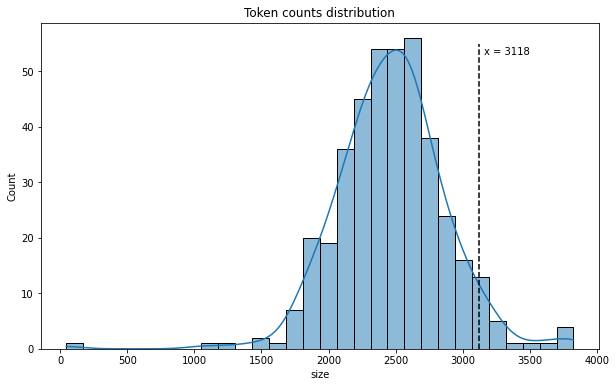

In [ ]:
# Plotting the distribution of the timeline sizes
fig, ax = plt.subplots(figsize=(10,6))

sns.histplot(x="size", data=timelines, kde=True, ax=ax)
plt.plot([sequence_length,sequence_length], [0,55], "k--")
plt.text(sequence_length + (timelines["size"].max() / 100) * 1, 53, f"x = {sequence_length}")
ax.set_title("Token counts distribution")

plt.show()

In [ ]:
# Count of timelines having less than 3119 words:
timelines[timelines["size"] <= 3118].shape[0]

380

In [ ]:
timelines.head(5)

,lang,userid,timeline,size
0,es,223d8277fe1f9895a83a385010218989,me gusta la valenciana es mucha mujer rt la cr...,2717
1,es,06579b519c2932ce09aa356b5f131931,chiste ninguno era en serio afeitate las cuchi...,3249
2,es,61b8736bbe890d488f44058b64736228,doctorado en care'raja dc donde te puedo depos...,2550
3,es,3e08a019827cd80b6d0756bf96663065,rt cómo va el efecto illa en catalunya ya está...,2961
4,es,73f77721bb14a116951e65daa1bc1d4a,cuidado si no me invitan a sus llamaditas oiga...,1923


## Removal of contractions and stopwords

In [ ]:
nltk.download('stopwords')

stops = {}

stops["en"] = stopwords.words("english")
stops["es"] = stopwords.words("spanish")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def remove_stops(text, lang):
    return " ".join([word for word in text.split() if word not in stops[lang]])

In [ ]:
# Fixing contractions for english
timelines.loc[timelines["lang"]=="en", "timeline"] = timelines.loc[timelines["lang"]=="en", "timeline"].apply(func=contractions.fix)

# Removal of english stopwords
timelines.loc[timelines["lang"]=="en", "timeline"] = timelines.loc[timelines["lang"]=="en", "timeline"].apply(func=remove_stops, args=("en",))

# Removal of spanish stopwords
timelines.loc[timelines["lang"]=="es", "timeline"] = timelines.loc[timelines["lang"]=="es", "timeline"].apply(func=remove_stops, args=("es",))

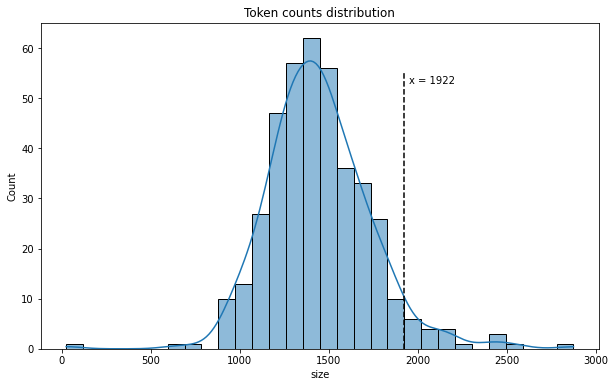

In [12]:
# After

# Computing the size of the timeline (number of words)
timelines["size"] = timelines["timeline"].str.split().str.len()

# Re-computing the sequence_length
sequence_length = int(timelines["size"].quantile(q=0.95))

# Plotting the distribution of the timeline sizes
fig, ax = plt.subplots(figsize=(10,6))

sns.histplot(x="size", data=timelines, kde=True, ax=ax)
plt.plot([sequence_length,sequence_length], [0,55], "k--")
plt.text(sequence_length + (timelines["size"].max() / 100) * 1, 53, f"x = {sequence_length}")
ax.set_title("Token counts distribution")

plt.show()

By removing English and Spanish stop-words (selectively), we managed to reduce the sequence size to 1922.

In [ ]:
timelines.to_csv("timelines_reduced.csv")

# Checkpoint 2

In [26]:
# We need to merge and separate to keep the correct truth order of the users
timelines = pd.read_csv("timelines_reduced.csv", index_col=0)
truth = pd.read_csv("truth.csv", index_col=0)

merged = pd.merge(left=timelines, right=truth, how="left", on="userid")

timelines = merged[["lang", "userid", "timeline", "size"]].copy()
truth = merged[["userid", "truth"]].copy()


In [19]:
timelines.head(5)

,lang,userid,timeline,size
0,es,223d8277fe1f9895a83a385010218989,gusta valenciana mucha mujer rt crítica pablo ...,1648
1,es,06579b519c2932ce09aa356b5f131931,chiste ninguno serio afeitate cuchillas afeita...,2143
2,es,61b8736bbe890d488f44058b64736228,doctorado care'raja dc puedo depositar único m...,1379
3,es,3e08a019827cd80b6d0756bf96663065,rt cómo va efecto illa catalunya gobernando rt...,1797
4,es,73f77721bb14a116951e65daa1bc1d4a,cuidado si invitan llamaditas oigan si verdd d...,1249


In [21]:
truth[truth["userid"]=="223d8277fe1f9895a83a385010218989"]

,userid,truth
153,223d8277fe1f9895a83a385010218989,1


In [27]:
truth[truth["userid"]=="223d8277fe1f9895a83a385010218989"]

,userid,truth
0,223d8277fe1f9895a83a385010218989,1


In [25]:
timelines.head(5)

,lang,userid,timeline,size
0,es,223d8277fe1f9895a83a385010218989,gusta valenciana mucha mujer rt crítica pablo ...,1648
1,es,06579b519c2932ce09aa356b5f131931,chiste ninguno serio afeitate cuchillas afeita...,2143
2,es,61b8736bbe890d488f44058b64736228,doctorado care'raja dc puedo depositar único m...,1379
3,es,3e08a019827cd80b6d0756bf96663065,rt cómo va efecto illa catalunya gobernando rt...,1797
4,es,73f77721bb14a116951e65daa1bc1d4a,cuidado si invitan llamaditas oigan si verdd d...,1249


In [20]:
merged.head(5)

,lang,userid,timeline,size,truth
0,es,223d8277fe1f9895a83a385010218989,gusta valenciana mucha mujer rt crítica pablo ...,1648,1
1,es,06579b519c2932ce09aa356b5f131931,chiste ninguno serio afeitate cuchillas afeita...,2143,1
2,es,61b8736bbe890d488f44058b64736228,doctorado care'raja dc puedo depositar único m...,1379,1
3,es,3e08a019827cd80b6d0756bf96663065,rt cómo va efecto illa catalunya gobernando rt...,1797,1
4,es,73f77721bb14a116951e65daa1bc1d4a,cuidado si invitan llamaditas oigan si verdd d...,1249,0


## Tokenization

In [29]:
max_features = 70000
tokenizer = Tokenizer(num_words=max_features)

tokenizer.fit_on_texts(timelines["timeline"])
word_index = tokenizer.word_index

In [30]:
len(word_index)

60202

In [ ]:
word_index

In [32]:
X = tokenizer.texts_to_sequences(timelines["timeline"])

In [33]:
len(X)

400

In [34]:
X_pad = pad_sequences(X, maxlen=sequence_length, padding="pre", truncating="pre")
X_pad.shape

(400, 1922)

In [35]:
y = truth["truth"].values

## Train / Test split

Let's shuffle and split the data, so we have 20% of test data.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42, shuffle=True)

print(f"Training data: {len(X_train)}")
print(f"Testing data : {len(X_test)}")

Training data: 320
Testing data : 80


In [37]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((320, 1922), (320,), (80, 1922), (80,))

## Words embedding

In [ ]:
glove_file = "glove.twitter.27B/glove.twitter.27B.100d.txt"

embeddings_index = dict()

f = open(glove_file)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()
print(f"Loaded {len(embeddings_index)} word vectors.")

Loaded 1193514 word vectors.


### Creating embedding matrix

In [38]:
# The one extra token is for oov (out of vocabulary) words
vocab_size = len(word_index) + 1
num_words  = len(word_index)

In [ ]:
# Create matrix
embedding_matrix = np.zeros((vocab_size, 100))

In [ ]:
# Fill the matrix
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix[1]

array([ 0.60470003,  0.89542001,  0.27923   ,  0.033489  ,  0.15873   ,
        0.18522   ,  0.30722001,  0.47444999,  0.44484001,  0.70450002,
        0.39528   , -0.19818   , -2.38840008,  0.095433  ,  0.10782   ,
        0.26262999,  0.36581999, -0.63849998, -0.22938   , -0.34722   ,
        0.10977   ,  0.37367001, -0.068053  , -0.39421001,  0.43471   ,
       -2.17939997, -0.47110999,  0.087237  ,  0.57989001, -0.020883  ,
       -0.0695    ,  0.25771001, -0.50190002,  0.41154   ,  1.21780002,
        0.47975999, -0.31573999,  0.52982998,  0.041575  ,  0.44973001,
       -1.53629994, -0.096062  , -0.27531001,  0.52771002,  0.028587  ,
        0.047935  , -0.59729999, -0.051772  ,  0.11377   , -0.40490001,
       -0.54856998, -0.65916002, -0.38132   , -0.39519   ,  0.42961001,
        0.74531001, -0.50838   ,  0.40391999,  0.62699002, -0.24798   ,
       -0.25386   ,  0.21867   , -0.072132  , -0.51783001, -0.054186  ,
       -0.66390997, -0.58223999,  0.060621  , -0.54000998,  0.72

In [ ]:
embeddings_index["biden"]

array([ 0.98429  ,  1.1696   ,  0.96791  ,  0.062263 ,  0.028928 ,
        0.46177  ,  0.37846  ,  0.23331  , -0.28526  , -0.56307  ,
        0.38495  , -0.33393  , -2.0887   ,  0.121    ,  0.53074  ,
       -0.30332  , -1.1706   , -0.95475  ,  0.031014 ,  0.8875   ,
       -0.057436 , -0.44268  ,  0.35306  , -0.1389   ,  0.18843  ,
        0.89854  ,  0.43902  , -0.1208   , -0.50787  , -0.42611  ,
        1.0742   , -0.093432 , -0.61786  ,  0.024065 , -0.4121   ,
       -0.13544  , -0.8457   ,  0.31473  , -0.052642 , -0.56414  ,
        0.4625   , -0.34873  ,  0.86304  , -0.059435 , -0.1659   ,
       -0.42984  , -0.59144  ,  0.16637  , -0.27325  , -0.18612  ,
       -0.43312  , -0.16529  ,  0.20865  ,  0.036786 , -0.49843  ,
       -0.16106  , -0.033889 , -0.36693  , -0.047321 , -0.48369  ,
        0.57318  , -0.19213  ,  0.34516  ,  0.088451 ,  1.0934   ,
        0.063112 ,  0.67888  ,  0.48681  ,  0.14371  ,  0.0094619,
       -0.047891 , -0.60278  ,  0.15129  , -0.86289  , -0.1472

In [ ]:
word_index["biden"]

67

In [ ]:
embedding_matrix[67]

array([ 0.98429   ,  1.16960001,  0.96790999,  0.062263  ,  0.028928  ,
        0.46177   ,  0.37845999,  0.23331   , -0.28525999, -0.56307   ,
        0.38495001, -0.33392999, -2.08870006,  0.121     ,  0.53074002,
       -0.30331999, -1.17060006, -0.95475   ,  0.031014  ,  0.88749999,
       -0.057436  , -0.44268   ,  0.35306001, -0.1389    ,  0.18843   ,
        0.89854002,  0.43902001, -0.1208    , -0.50787002, -0.42611   ,
        1.07420003, -0.093432  , -0.61786002,  0.024065  , -0.41209999,
       -0.13544001, -0.84570003,  0.31472999, -0.052642  , -0.56414002,
        0.46250001, -0.34873   ,  0.86303997, -0.059435  , -0.16590001,
       -0.42984   , -0.59144002,  0.16637   , -0.27325001, -0.18612   ,
       -0.43312001, -0.16529   ,  0.20864999,  0.036786  , -0.49843001,
       -0.16106001, -0.033889  , -0.36693001, -0.047321  , -0.48368999,
        0.57318002, -0.19213   ,  0.34516001,  0.088451  ,  1.0934    ,
        0.063112  ,  0.67887998,  0.48681   ,  0.14371   ,  0.00

In [ ]:
def check_coverage(vocab, embeddings_index):
    # save in a all words for which we have an embedding in pretrained glove
    a = {}

    #save in oov all wors for which we do not have an embedding in pretrained glove
    oov = {}

    k = 0
    i = 0
    for word in tqdm(word_index):
        try:
            a[word] = embeddings_index[word]
            k += word_index[word]
        except:
            oov[word] = word_index[word]
            i += word_index[word]
            pass
    
    print(f"\nFound embeddings for {(len(a)/len(word_index)):.2%} of vocab.")
    print(f"Found embeddings for {k/(k + i):.2%} of all text.")

    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

In [ ]:
oov = check_coverage(word_index, embeddings_index)

100%|██████████| 60202/60202 [00:00<00:00, 527962.57it/s]
Found embeddings for 83.79% of vocab.
Found embeddings for 77.99% of all text.



In [ ]:
oov[-10:]

[('podemita', 2957),
 ('kavanaugh', 2943),
 ('potorra', 2639),
 ('ghostcrew', 2257),
 ("trump's", 2253),
 ("biden's", 1869),
 ('marlaska', 1720),
 ('brexit', 1495),
 ('arrimadas', 1032),
 ('covid', 159)]

### Releasing some memory

In [ ]:
# del(embeddings_index)
del(X)
del(X_pad)
del(word_index)

In [ ]:
# Storing embedding_matrix into pickle
file = open("embedding_matrix_peter.p", "wb")
pickle.dump(embedding_matrix, file)
file.close()

In [39]:
# Reopening embedding_matrix from pickle
file = open("embedding_matrix_peter.p", "rb")
embedding_matrix = pickle.load(file)      
file.close()

# Baseline model

## transform tweets into tfidf 

Laszlo , possible steps: remove stop words, then lemmatization etc

## Setup RF 

## run data through RF

## analys the outcomes

# LSTM model

## Build LSTM model

In [ ]:
# Uli will do this

# DRAFT Ul this needs to be corrected
# model = Sequential( )
# embedding_neurons = 64
# model.add(tensorflow.keras.layers.Embedding(input_dim= xxx, output_dim=embedding_neurons))  
# LSTM_neurons = 250  # commonly used for GRU
# model.add(tensorflow.keras.layers.LSTM(LSTM_neurons , return_sequences=True)) 
# dense_neurons = xxx    # how many untis???
# model.add(tensorflow.keras.layers.TimeDistributed(tensorflow.keras.layers.Dense(dense_neurons, activation='softmax')))  

import tensorflow
from tensorflow.keras import layers
from tensorflow import keras

# Input for variable-length sequences of integers
inputs = tensorflow.keras.Input(shape=(None,), dtype="int32")
# Embed each integer in a 128-dimensional vector
max_features = len(text_tokenizer.word_index)
x = tensorflow.keras.layers.Embedding(max_features, 128)(inputs)
# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
# Add a classifier
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 128)         9077632   
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 9,275,393
Trainable params: 9,275,393
Non-trainable params: 0
_________________________________________________________________


Creating embedding layer using `embedding_matrix`

In [40]:
# input  = vocab_size
# output = 100
# weights are from embedding_matrix
# set trainable = False
embedding_layer = Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=sequence_length, trainable=False)

In [41]:
# =============================================================================
# Build model 1
# =============================================================================

def build_model(nb_units_lstm, nb_units_dense):
  model = tf.keras.Sequential()
  model.add(embedding_layer)
  model.add(Bidirectional(LSTM(nb_units_lstm)))
  model.add(Dense(nb_units_dense, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  return model

In [42]:
model1 = build_model(300,100)
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1922, 100)         6020300   
                                                                 
 bidirectional (Bidirectiona  (None, 600)              962400    
 l)                                                              
                                                                 
 dense (Dense)               (None, 100)               60100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 7,042,901
Trainable params: 1,022,601
Non-trainable params: 6,020,300
______________________________________

In [43]:
# =============================================================================
# Compile and train model
# =============================================================================

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model1.compile(loss='binary_crossentropy', optimizer=opt, \
              metrics=['accuracy'])
    

history1 = model1.fit(X_train, y_train, batch_size=128,
          epochs=15, validation_split=0.2,  shuffle=False)

Epoch 1/15
2/2 [==============================] - 88s 47s/step - loss: 0.6967 - accuracy: 0.4922 - val_loss: 0.6967 - val_accuracy: 0.4688
Epoch 2/15
2/2 [==============================] - 82s 46s/step - loss: 0.6899 - accuracy: 0.5039 - val_loss: 0.7001 - val_accuracy: 0.4688
Epoch 3/15
2/2 [==============================] - 79s 43s/step - loss: 0.6866 - accuracy: 0.5469 - val_loss: 0.7022 - val_accuracy: 0.4375
Epoch 4/15
2/2 [==============================] - 77s 41s/step - loss: 0.6806 - accuracy: 0.5703 - val_loss: 0.7038 - val_accuracy: 0.4219
Epoch 5/15
2/2 [==============================] - 76s 42s/step - loss: 0.6741 - accuracy: 0.5859 - val_loss: 0.7059 - val_accuracy: 0.4062
Epoch 6/15
2/2 [==============================] - 77s 42s/step - loss: 0.6754 - accuracy: 0.5938 - val_loss: 0.7080 - val_accuracy: 0.4375
Epoch 7/15
2/2 [==============================] - 77s 41s/step - loss: 0.6730 - accuracy: 0.5703 - val_loss: 0.7098 - val_accuracy: 0.4375
Epoch 8/15
2/2 [===========

In [49]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()

In [63]:
# This function will retrieve and plot all observed model performance metrics

def show_history(s, suptitle="", scale = "linear"):
    
    # Automatically retrieve list of all metrics from history
    metrics = list(s.history.keys())[:len(list(s.history.keys()))//2]

    # Calculate amount of metrics
    nrows = len(metrics)

    # Set figure size to 12 x N*5 (where N is number of metrics [nrows])
    fig, axs = plt.subplots(nrows=nrows, ncols=1, figsize=(12, 5 * nrows))

    fig.suptitle(suptitle)

    index = -1

    for metric in metrics:
        index+=1

        axs[index].plot(s.history[metric], label=metric)
        axs[index].plot(s.history["val_"+metric], label="val_"+metric)
        axs[index].set_yscale(scale)
        axs[index].legend()
        axs[index].grid(b=True, which="major", axis="y")
        axs[index].set_title("Observed "+metric)
    
    plt.show()
    plt.close()

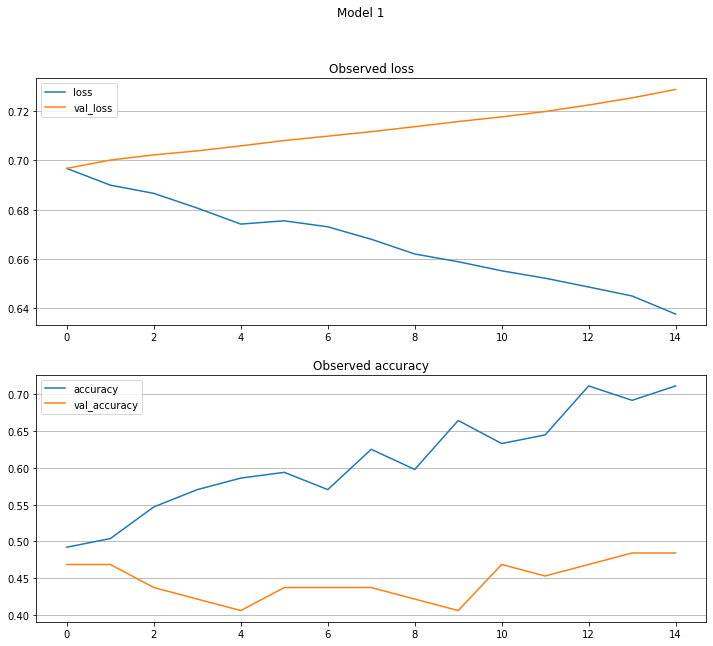

In [64]:
show_history(history1, suptitle="Model 1")

In [51]:
model1.evaluate(X_test, y_test)

3/3 [==============================] - 11s 3s/step - loss: 0.7005 - accuracy: 0.5875


[0.7005405426025391, 0.5874999761581421]

### Model 2

In [52]:
# =============================================================================
# Build model 2
# =============================================================================

def build_model_2(nb_units_lstm, nb_units_dense):
  model = tf.keras.Sequential()
  model.add(embedding_layer)
  model.add(Bidirectional(LSTM(nb_units_lstm)))
  model.add(BatchNormalization())
  model.add(Dense(nb_units_dense, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  return model

In [53]:
model2 = build_model_2(300,100)
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1922, 100)         6020300   
                                                                 
 bidirectional_2 (Bidirectio  (None, 600)              962400    
 nal)                                                            
                                                                 
 batch_normalization (BatchN  (None, 600)              2400      
 ormalization)                                                   
                                                                 
 dense_4 (Dense)             (None, 100)               60100     
                                                                 
 batch_normalization_1 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                      

In [58]:
# =============================================================================
# Compile and train model
# =============================================================================

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model2.compile(loss='binary_crossentropy', optimizer=opt, \
              metrics=['accuracy'])
    

history2 = model2.fit(X_train, y_train, batch_size=128,
          epochs=15, validation_split=0.2,  shuffle=True)

Epoch 1/15
2/2 [==============================] - 87s 47s/step - loss: 0.9621 - accuracy: 0.5352 - val_loss: 0.7100 - val_accuracy: 0.4375
Epoch 2/15
2/2 [==============================] - 80s 45s/step - loss: 0.8864 - accuracy: 0.5430 - val_loss: 0.7093 - val_accuracy: 0.4375
Epoch 3/15
2/2 [==============================] - 77s 42s/step - loss: 0.8239 - accuracy: 0.5273 - val_loss: 0.7087 - val_accuracy: 0.4688
Epoch 4/15
2/2 [==============================] - 76s 42s/step - loss: 0.7414 - accuracy: 0.5859 - val_loss: 0.7082 - val_accuracy: 0.4219
Epoch 5/15
2/2 [==============================] - 78s 42s/step - loss: 0.7156 - accuracy: 0.6094 - val_loss: 0.7076 - val_accuracy: 0.4062
Epoch 6/15
2/2 [==============================] - 75s 41s/step - loss: 0.6699 - accuracy: 0.6445 - val_loss: 0.7070 - val_accuracy: 0.4062
Epoch 7/15
2/2 [==============================] - 78s 43s/step - loss: 0.5423 - accuracy: 0.7070 - val_loss: 0.7064 - val_accuracy: 0.4219
Epoch 8/15
2/2 [===========

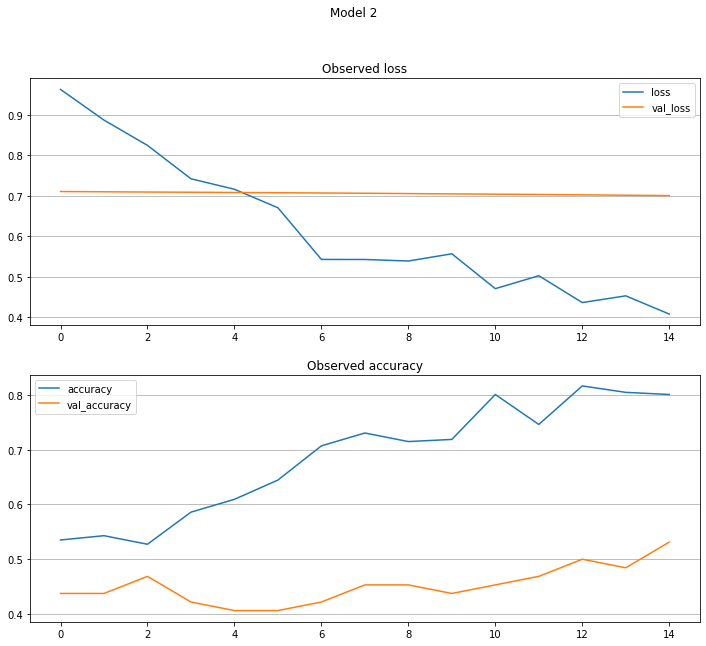

In [65]:
show_history(history2, suptitle="Model 2")

In [66]:
history2.history['val_loss']

[0.7100014090538025,
 0.7093348503112793,
 0.7086883783340454,
 0.7081838846206665,
 0.7075579166412354,
 0.7069840431213379,
 0.7063509821891785,
 0.7057157754898071,
 0.7049040794372559,
 0.7040853500366211,
 0.7033768892288208,
 0.7026864290237427,
 0.7017615437507629,
 0.7008079886436462,
 0.6998765468597412]

In [60]:
model2.evaluate(X_test, y_test)

3/3 [==============================] - 11s 3s/step - loss: 0.7002 - accuracy: 0.4250


[0.7002028226852417, 0.42500001192092896]

# Compare the results using F1 measure

In [54]:
def conf_matrix(yhat, title):
    fig, ax = plt.subplots(figsize=(12,6))
    ConfusionMatrixDisplay.from_predictions(y_test, yhat, ax=ax)
    ax.set_title("Confusion matrix")
    ax.grid(False)
    plt.show()

In [56]:
y_pred1 = model1.predict(X_test) > 0.5

score1 = f1_score(y_test, y_pred1)

score1

0.5074626865671642

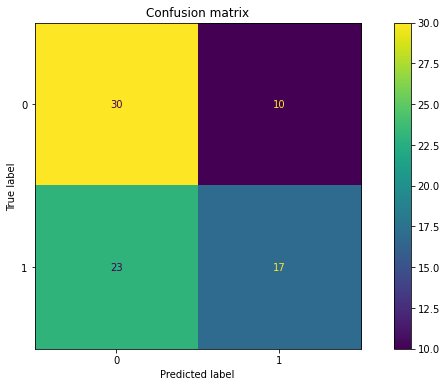

In [57]:
conf_matrix(y_pred1, "Model 1")

In [61]:
y_pred2 = model2.predict(X_test) > 0.5

score2 = f1_score(y_test, y_pred2)

score2

0.37837837837837834

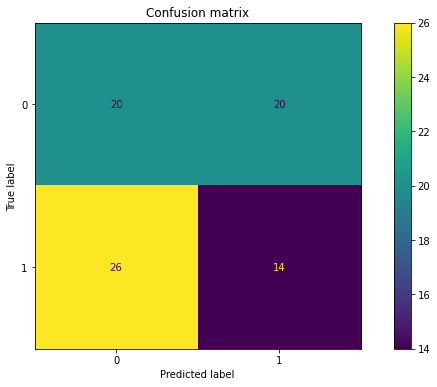

In [62]:
conf_matrix(y_pred2, "Model 2")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d542cd96-5114-4360-b07a-18b11b986ecd' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>